GOAL : 

1.   Predicting the Fastest and Average shipment duration of goods/product from the date of order. 
2.   Late_risk_classification model for predicting order with high risk(1) and low risk(0).



# Importing necessary Libraries and Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('../input/dataco-smart-supply-chain-for-big-data-analysis/DataCoSupplyChainDataset.csv',header= 0,encoding='unicode_escape')
pd.set_option('display.max_columns',None)
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# Feature Engineering

In [3]:
#Converting categorical features that represent date and time to datetime datatype.
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])
data['shipping_date']=pd.to_datetime(data['shipping date (DateOrders)'])

In [4]:
data['order_year'] = pd.DatetimeIndex(data['order_date']).year
data['order_month'] = pd.DatetimeIndex(data['order_date']).month
data['order_day'] = pd.DatetimeIndex(data['order_date']).day
data['shipping_year'] = pd.DatetimeIndex(data['shipping_date']).year
data['shipping_month'] = pd.DatetimeIndex(data['shipping_date']).month
data['shipping_day'] = pd.DatetimeIndex(data['shipping_date']).day

# Feature Selection

In [5]:
new_dataset_features = ['Type','Days for shipping (real)','Days for shipment (scheduled)','Late_delivery_risk','Benefit per order',
                        'Sales per customer','Latitude','Longitude','Shipping Mode','Order Status','Order Region',
                        'Order Country','Order City','Market','Delivery Status','order_day','order_month','order_year',
                        'shipping_day','shipping_month','shipping_year']
len(new_dataset_features)

21

In [6]:
new_data = data[new_dataset_features]
new_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Benefit per order,Sales per customer,Latitude,Longitude,Shipping Mode,Order Status,Order Region,Order Country,Order City,Market,Delivery Status,order_day,order_month,order_year,shipping_day,shipping_month,shipping_year
0,DEBIT,3,4,0,91.250000,314.640015,18.251453,-66.037056,Standard Class,COMPLETE,Southeast Asia,Indonesia,Bekasi,Pacific Asia,Advance shipping,31,1,2018,3,2,2018
1,TRANSFER,5,4,1,-249.089996,311.359985,18.279451,-66.037064,Standard Class,PENDING,South Asia,India,Bikaner,Pacific Asia,Late delivery,13,1,2018,18,1,2018
2,CASH,4,4,0,-247.779999,309.720001,37.292233,-121.881279,Standard Class,CLOSED,South Asia,India,Bikaner,Pacific Asia,Shipping on time,13,1,2018,17,1,2018
3,DEBIT,3,4,0,22.860001,304.809998,34.125946,-118.291016,Standard Class,COMPLETE,Oceania,Australia,Townsville,Pacific Asia,Advance shipping,13,1,2018,16,1,2018
4,PAYMENT,2,4,0,134.210007,298.250000,18.253769,-66.037048,Standard Class,PENDING_PAYMENT,Oceania,Australia,Townsville,Pacific Asia,Advance shipping,13,1,2018,15,1,2018


In [7]:
model_data = new_data

In [8]:
#One-Hot encoding categotical variables in the data
model_data = pd.get_dummies(model_data)
model_data.shape

(180519, 3823)

# Model Building

*  Target features : Days for shipping (real), Days for shipment (scheduled)
*  Problem type : Multi-class Regression




In [9]:
# Splitting independent and dependent features from the processsed dataset
x = model_data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1)
y = model_data[['Days for shipping (real)','Days for shipment (scheduled)']]
x.shape,y.shape

((180519, 3821), (180519, 2))

In [10]:
# Splitting data into train and test. Alloting 25% data for testing
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20)

Building Data Pipeline using sci-kit learn library

In [11]:
sc=StandardScaler() 
#No standard Scaling is not required for Decision Trees are tree-based alogorithms and do not need normalization or standard scaling
#pc=PCA()
model=DecisionTreeRegressor(splitter='best',min_samples_split=2)
pipe=Pipeline(steps=[('sc',sc),('model',model)])

# Hyper-parameter Tuning

In [12]:
max_depth = [4,6,8,12]
parameters = dict(model__max_depth=max_depth)

In [13]:
clf = GridSearchCV(pipe,parameters)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

In [14]:
print('Best max_depth: ',clf.best_estimator_.get_params()['model__max_depth'])

Best max_depth:  12


# Model Evaluation

In [15]:
#Function for estimating r2_score, mean_squared_error, mean_absolute_error
def metrics(y_test,pred):
    a =r2_score(y_test,pred)
    b =mean_squared_error(y_test,pred)
    c =mean_absolute_error(y_test,pred)
    print('The r-squared score of the model is ',a)
    print('The mean squared error is',b)
    print('The mean accuracy score is',c)

In [16]:
metrics(y_test,pred)

The r-squared score of the model is  0.9445170432644021
The mean squared error is 0.14691396250900762
The mean accuracy score is 0.18456386641472128


In [18]:
#from sklearn.model_selection import cross_validate
#cv_results = cross_validate(clf,x,y,cv=4)
#cv_results

# Late_delivery_prediction 
Using Fastest product shipment and Normal shipment duration(in days) features from predictions

In [19]:
#Converting the predicted output array to dataframe
Prediction = pd.DataFrame(pred)
prediction = Prediction.rename(columns={0:'Fastest_shipment',1:'Avg_shipment'})
prediction.head()

,Fastest_shipment,Avg_shipment
0,2.000000,1.0
1,5.488936,4.0
2,4.447686,2.0
3,5.558883,4.0
4,5.469016,4.0


Risk in delivery is a feature that highly corresponds and correlates to Fastest Shipment and Avg_shipment duration in days. If the fastest shipment duration is greater than avg_shipment, then late delivery risk is heavier as the scheduled days are outnumbered. Similarly, if avg_shipment values are greater than former, then there is a high probability for FAST/EARLY delivery of goods to customers

In [20]:
# Statiscal modelling
prediction['risk'] = np.where(prediction['Avg_shipment'] >= prediction['Fastest_shipment'],0,1)

In [21]:
prediction.head()

,Fastest_shipment,Avg_shipment,risk
0,2.000000,1.0,1
1,5.488936,4.0,1
2,4.447686,2.0,1
3,5.558883,4.0,1
4,5.469016,4.0,1


In [22]:
l = prediction['risk']
m = x_test['Late_delivery_risk']
l.shape,m.shape

((36104,), (36104,))

Classification Model Evaluation

In [23]:
# Defining a function to evaluate our statiscal model for Late_delivery_risk_prediction
def evaluation_risk_factor(l,m):
  print('The accuracy of the risk predictor model is ',accuracy_score(l,m))
  print('Some of the key classification metrics are :')
  print(classification_report(l,m))
  ax=plt.subplot()
  sns.heatmap(confusion_matrix(l,m),annot=True,ax=ax);
  ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
  ax.set_title('Confusion matrix for Risk Delivery classfication');

The accuracy of the risk predictor model is  0.8446432528251717
Some of the key classification metrics are :
              precision    recall  f1-score   support

           0       0.66      1.00      0.79     10777
           1       1.00      0.78      0.88     25327

    accuracy                           0.84     36104
   macro avg       0.83      0.89      0.83     36104
weighted avg       0.90      0.84      0.85     36104



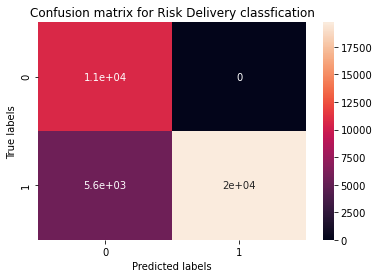

In [24]:
evaluation_risk_factor(l,m)
#comparing_late_delivery_risk_values of predicted and actual values.

# Comparing the performance of the Late delivery classifier

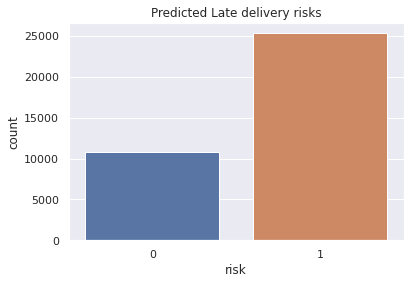

In [25]:
sns.set(style="darkgrid")
ax=sns.countplot(x="risk",data=prediction).set_title('Predicted Late delivery risks')

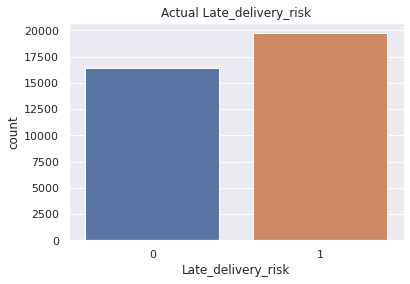

In [26]:
bx=sns.countplot(x='Late_delivery_risk',data=x_test).set_title('Actual Late_delivery_risk')

# Saving the trained regression model to pickle file

In [27]:
filename = 'Shipping_duration_estimator.pkl'
pickle.dump(model,open(filename,'wb'))

In [31]:
mod = model.fit(x,y)

[Text(108.82297774835615, 216.5632258064516, 'X[18] <= 0.5\nmse = 2.263\nsamples = 180519\nvalue = [[3.498]\n[2.932]]'),
 Text(14.833301348451625, 214.80967741935484, 'X[17] <= 0.5\nmse = 1.575\nsamples = 72767\nvalue = [[2.76]\n[1.35]]'),
 Text(2.898561925090947, 213.05612903225807, 'X[15] <= 0.5\nmse = 0.351\nsamples = 37551\nvalue = [[1.605]\n[0.741]]'),
 Text(2.797742379870392, 211.3025806451613, 'X[0] <= 0.5\nmse = 0.125\nsamples = 9737\nvalue = [[0.478]\n[0.0]]'),
 Text(2.6969228346498375, 209.54903225806453, 'X[3820] <= 0.5\nmse = 0.018\nsamples = 5283\nvalue = [[0.038]\n[0.0]]'),
 Text(2.5961032894292826, 207.79548387096773, 'X[7] <= 2016.5\nmse = 0.124\nsamples = 444\nvalue = [[0.457]\n[0.0]]'),
 Text(1.814751813969984, 206.04193548387096, 'X[6] <= 2.5\nmse = 0.115\nsamples = 294\nvalue = [[0.357]\n[0.0]]'),
 Text(1.4618834056980428, 204.2883870967742, 'X[8] <= 19.5\nmse = 0.106\nsamples = 49\nvalue = [[0.694]\n[0.0]]'),
 Text(1.2602443152569334, 202.53483870967742, 'X[1301] <

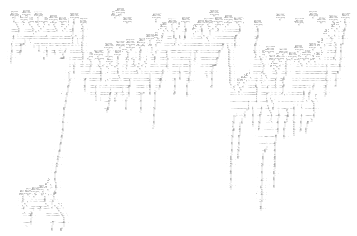

In [32]:
tree.plot_tree(mod)

In [34]:
import graphviz 
dot_data = tree.export_graphviz(mod, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("dcmodel") 

'dcmodel.pdf'

In [35]:
dot_data = tree.export_graphviz(mod, out_file=None,
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

NameError: name 'iris' is not defined